# Assignment3
Repository Link: [Github](https://github.com/awakn123/CS6120NLP/tree/main)

Members: Yun Cao, Yue Liu, Nan Chen, Muyang Cheng

# Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [1]:
# data link: https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
import pandas as pd
import json

data = []
with open('./Clothing_Shoes_and_Jewelry_5.json'
            , 'r') as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)
#df = df.sample(1000)
print(df.head())

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  
0  Great tutu-  not cheaply made      1297468800  02 12, 2011  
1                    Very Cute!!      1358553600  01 19, 201

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, and other tasks as
you deem necessary.

In [2]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    text = text.strip()
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

df["reviewText2"] = df["reviewText"].apply(lambda x: clean_text(x))
df["summary2"] = df["summary"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muyangcheng329/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/muyangcheng329/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Part 2: Word2Vec, fasttext embeddings
2.1 Create 100D vectors using both Word2Vec (CBOW and SkipGram separately), and fasttext algorithms

In [3]:
from gensim.models import Word2Vec
from gensim.models import FastText

sentences = [review.split() for review in df["reviewText2"]]

# 100D
# Word2Vec CBOW Model
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
#cbow_model.save("cbow_word2vec.model")

# Word2Vec Skip-gram Model
skipgram_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)
#skipgram_model.save("skipgram_word2vec.model")

# FastText Model
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=1, sg=1)
#fasttext_model.save("fasttext.model")


In [4]:
# 200D
# Word2Vec CBOW Model
cbow_model_200d = Word2Vec(sentences, vector_size=200, window=5, min_count=1, sg=0)

# Word2Vec Skip-gram Model
skipgram_model_200d = Word2Vec(sentences, vector_size=200, window=5, min_count=1, sg=1)

# FastText Model
fasttext_model_200d = FastText(sentences, vector_size=200, window=5, min_count=1, sg=1)

In [5]:
# 300D
# Word2Vec CBOW Model
cbow_model_300d = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)

# Word2Vec Skip-gram Model
skipgram_model_300d = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=1)

# FastText Model
fasttext_model_300d = FastText(sentences, vector_size=300, window=5, min_count=1, sg=1)

2.2 Average the vectors to create new average vector columns in the df

In [6]:
import numpy as np
def get_average_word2vec_embeddings(review, model):
    words = review.split()
    embeddings = [model.wv[word] for word in words if word in model.wv.key_to_index]
    if len(embeddings) == 0:
        return [0]*model.vector_size
    return list(np.mean(embeddings, axis=0))

df_cbow_model = df.copy()
embeddings = df_cbow_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, cbow_model))
for i in range(cbow_model.vector_size):
    df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i]) 
print(df_cbow_model.head())

df_skipgram_model = df.copy()
embeddings = df_skipgram_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, skipgram_model))
for i in range(skipgram_model.vector_size):
    df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
print(df_skipgram_model.head())

df_fasttext_model = df.copy()
embeddings = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model))
for i in range(fasttext_model.vector_size):
    df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
print(df_fasttext_model.head())

/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usual

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This 

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This 

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

2.3 Perform EDA to analyze associations between vectors from the three methods above.


Analyze Words


In [7]:
# Select 100 common words in three models
words = list(cbow_model.wv.key_to_index.keys())[:100]

# Extract the vectors for these common words from each model
cbow_vectors = np.array([cbow_model.wv[word] for word in words])
skipgram_vectors = np.array([skipgram_model.wv[word] for word in words])
fasttext_vectors = np.array([fasttext_model.wv[word] for word in words])

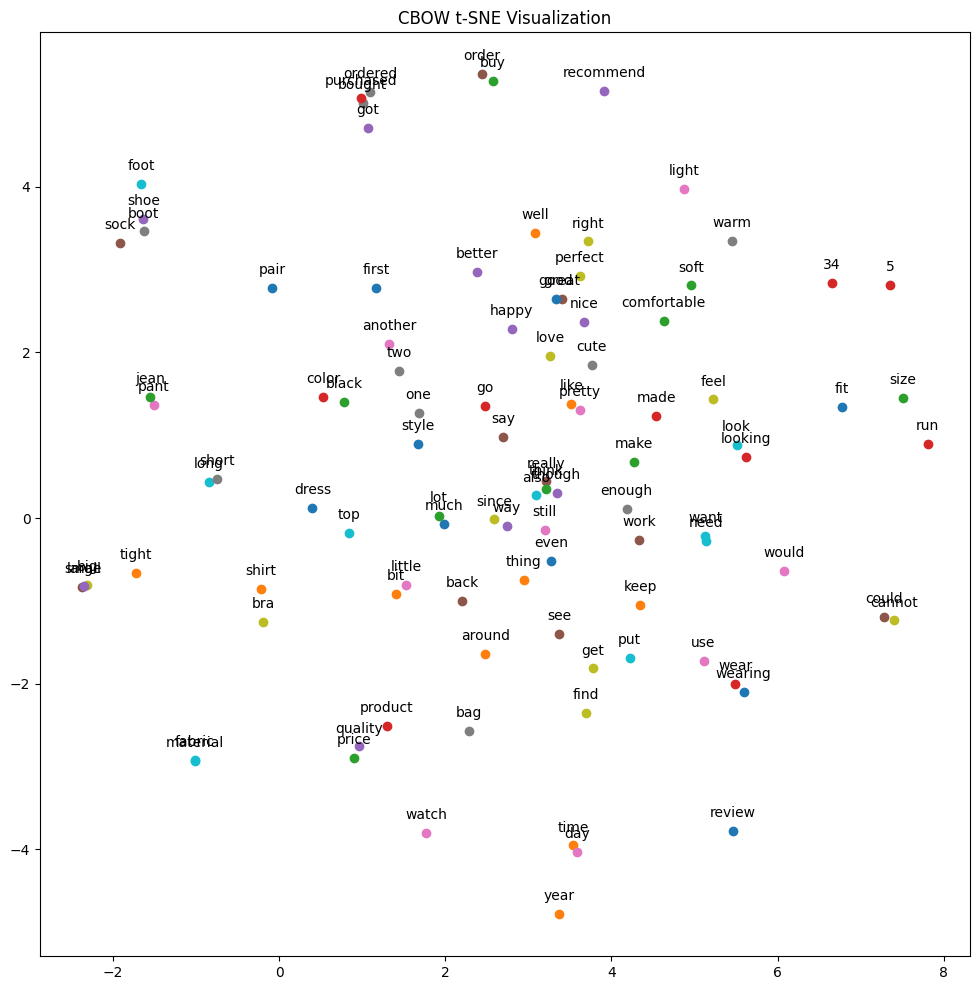

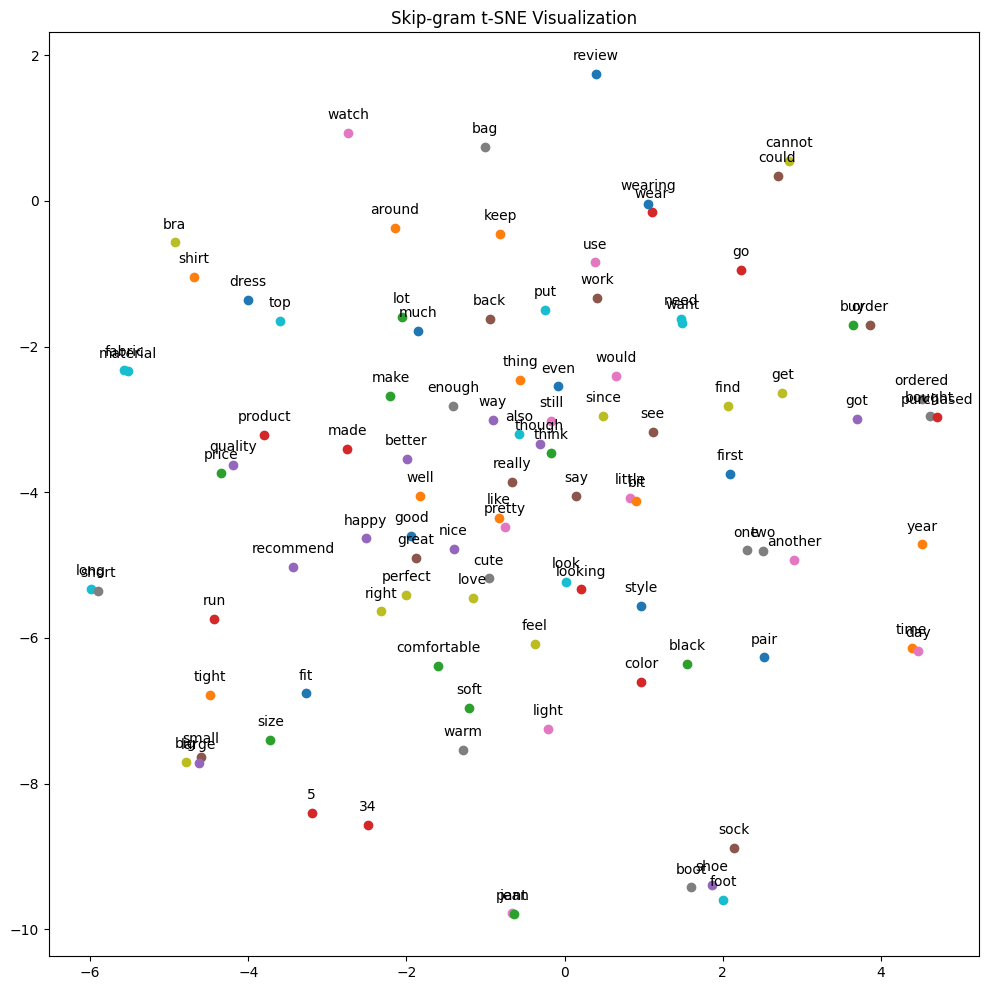

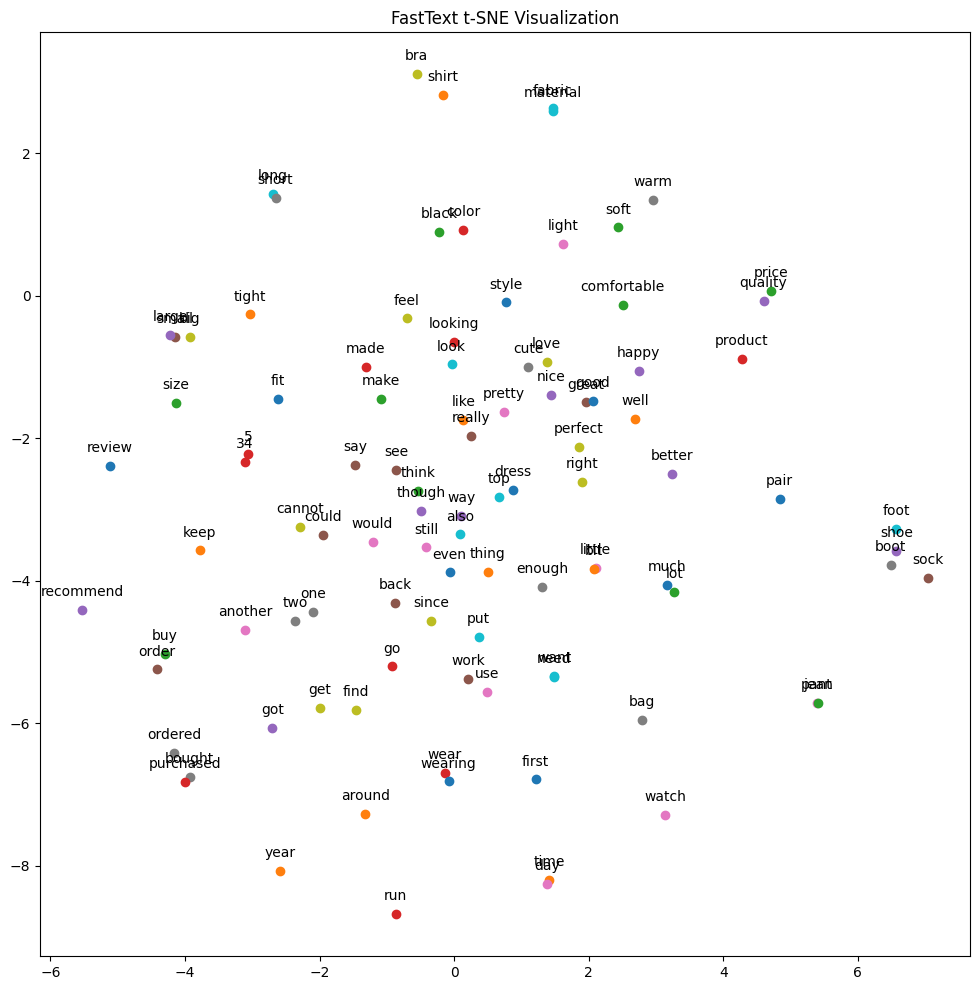

In [8]:
# Visualization with t-SNE
#Use t-SNE to reduce the dimensionality of your word vectors to two or three dimensions.
#Plot the results to see how words cluster together.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_word_vectors(model_vectors, words, title='Word Vectors Visualization'):
    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(model_vectors)
    plt.figure(figsize=(12, 12))
    for i, word in enumerate(words):
        plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1])
        plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(title)

visualize_word_vectors(cbow_vectors, words, 'CBOW t-SNE Visualization')
visualize_word_vectors(skipgram_vectors, words, 'Skip-gram t-SNE Visualization')
visualize_word_vectors(fasttext_vectors, words, 'FastText t-SNE Visualization')
plt.show()

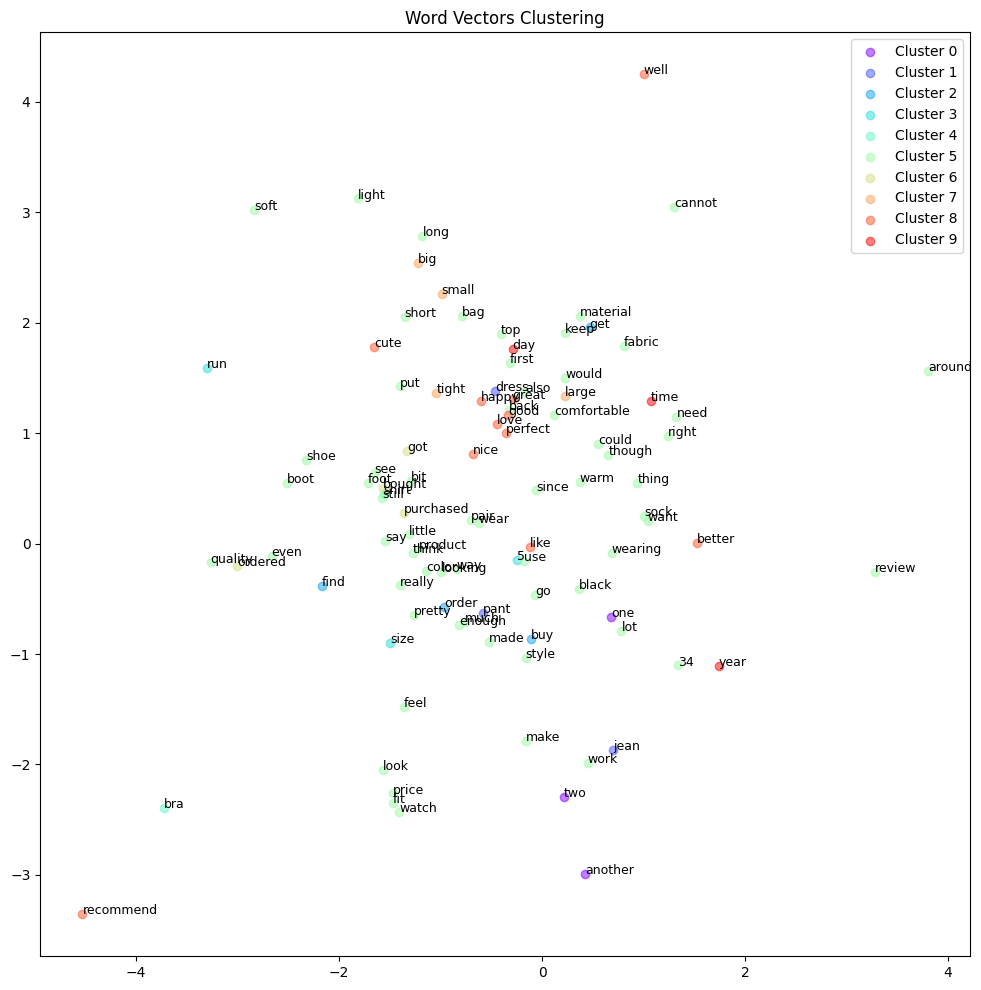

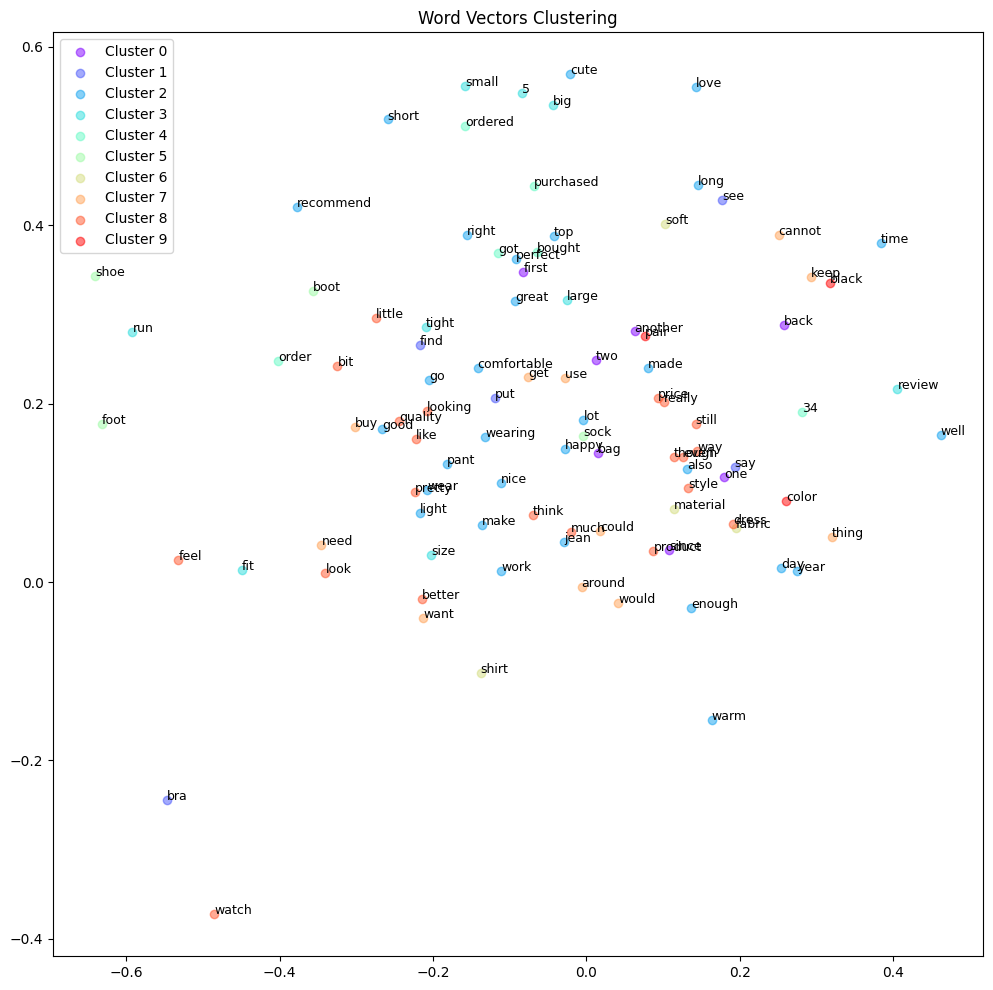

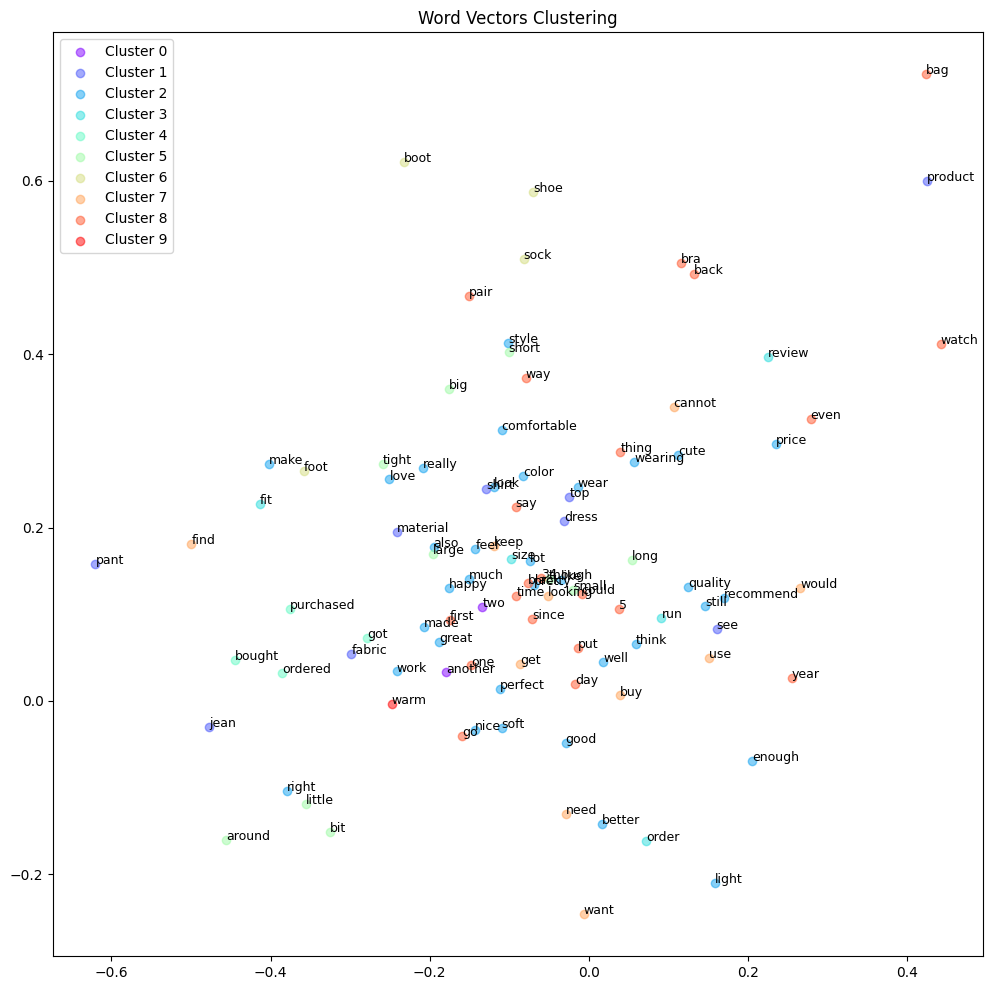

In [9]:
# Clustering with KMeans
# Apply clustering algorithms like K-Means on the word vectors.
# Analyze the clusters to see which words are grouped together by the model.
from sklearn.cluster import KMeans


def cluster_and_plot_words(model_vectors, common_words, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(model_vectors)
    cluster_map = {i: [] for i in range(n_clusters)}
    for word, label in zip(common_words, labels):
        cluster_map[label].append(word)

    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    plt.figure(figsize=(12, 12))
    
    for cluster_id in range(n_clusters):
        cluster_indices = [i for i, label in enumerate(labels) if label == cluster_id]
        cluster_points = model_vectors[cluster_indices]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.5)
    
    for i, word in enumerate(common_words):
        plt.text(model_vectors[i, 0], model_vectors[i, 1], word, fontsize=9)
    
    plt.title('Word Vectors Clustering')
    plt.legend()
    plt.show()
    
    return cluster_map

cbow_clusters = cluster_and_plot_words(cbow_vectors, words, n_clusters=10)
skipgram_clusters = cluster_and_plot_words(skipgram_vectors, words, n_clusters=10)
fasttext_clusters = cluster_and_plot_words(fasttext_vectors, words, n_clusters=10)

In [10]:
# Similarity Analysis
# Compute the cosine similarity between word vectors
from scipy.spatial.distance import cosine
from itertools import combinations
from random import sample


vocab = list(cbow_model.wv.index_to_key)
single_word_vocab = [word for word in vocab if '_' not in word and ' ' not in word]
selected_words = sample(single_word_vocab, 20)
pairs = [(selected_words[i], selected_words[i+1]) for i in range(0, 20, 2)]

def compare_similarity(word1, word2, model):
    similarity = 1 - cosine(model.wv[word1], model.wv[word2])
    return similarity

def generate_combined_similarity_table(pairs, models):
    data = []
    for pair in pairs:
        word1, word2 = pair
        similarities = [compare_similarity(word1, word2, model) for model in models]
        data.append([word1, word2] + similarities)
    
    column_names = ['Word1', 'Word2'] + [f'{name} Similarity' for name in ['CBOW 100D', 'Skip-gram 100D', 'FastText 100D', 'CBOW 200D', 'Skip-gram 200D', 'FastText 200D', 'CBOW 300D', 'Skip-gram 300D', 'FastText 300D']]
    return pd.DataFrame(data, columns=column_names)

models = [cbow_model, skipgram_model, fasttext_model, cbow_model_200d, skipgram_model_200d, fasttext_model_200d, cbow_model_300d, skipgram_model_300d, fasttext_model_300d]
similarity_table = generate_combined_similarity_table(pairs, models)

display(similarity_table)

,Word1,Word2,CBOW 100D Similarity,Skip-gram 100D Similarity,FastText 100D Similarity,CBOW 200D Similarity,Skip-gram 200D Similarity,FastText 200D Similarity,CBOW 300D Similarity,Skip-gram 300D Similarity,FastText 300D Similarity
0,targeting,atlas,0.722697,0.823284,0.537882,0.585097,0.803195,0.467600,0.553470,0.815727,0.469703
1,bodyfitthe,lisle,0.499216,0.859900,0.546822,0.512233,0.833935,0.491624,0.492801,0.815790,0.491413
2,wonderfulbut,12hr,0.641439,0.846650,0.582212,0.430465,0.844406,0.554423,0.322673,0.823378,0.523821
3,misreading,admitting,0.508684,0.833860,0.688579,0.421800,0.827083,0.618910,0.394090,0.788289,0.552887
4,rocked,clicked,0.455899,0.457509,0.617214,0.339234,0.382215,0.536482,0.300449,0.360134,0.505193
5,641,organism,0.732664,0.879698,0.450469,0.684064,0.871228,0.389366,0.820120,0.856036,0.373627
6,anytime,transpired,0.053428,0.411259,0.454218,0.073130,0.416385,0.404658,0.052167,0.395836,0.384542
7,sloppily,screwdriver,0.223717,0.587659,0.428698,0.153610,0.555271,0.373865,0.198246,0.557921,0.370464
8,cred,sudlety,0.446512,0.861025,0.512814,0.375395,0.858994,0.450071,0.582143,0.830315,0.395954
9,shifter,senile,0.247981,0.771565,0.517768,0.180341,0.780685,0.431162,0.286600,0.757388,0.364697


# Part 3: Sentiment Analysis

In [11]:


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Convert the ratings to 0 for negative and 1 for positive
def convert_rating_to_sentiment(overall):
  if overall in [1, 2]:
      return 0  # Negative sentiment
  elif overall in [4, 5]:
      return 1  # Positive sentiment
  # Optionally handle unexpected cases, though all cases should be covered
  return None

def convertAndReduceDimension(df):
		df = df.reset_index().rename(columns={'index': 'original_index'})
		df_filtered = df[df['overall'] != 3]
		df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
		vector_cols = [col for col in df_filtered.columns if col.startswith('w2v_emb_')]
		X = df_filtered[vector_cols]
		scaler = StandardScaler()
		X_scaled = scaler.fit_transform(X)

		# Step 2: Apply PCA to retain 90% of the variance
		pca = PCA(n_components=0.9)  # n_components set to 0.9 means PCA will select the minimum number of components that retain 90% of the variance
		X_pca = pca.fit_transform(X_scaled)

		# Create a DataFrame with the PCA features
		df_pca = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])

		# Optionally, if you want to include the sentiment back into the PCA-transformed dataset
		df_pca['sentiment'] = df_filtered['sentiment'].values
		df_pca['original_index'] = df_filtered['original_index'].values

		return df_pca
  
df_cbow = convertAndReduceDimension(df_cbow_model)
df_skipgram = convertAndReduceDimension(df_skipgram_model)
df_fasttext = convertAndReduceDimension(df_fasttext_model)

# Define your DataFrame to hold the results
results_df = pd.DataFrame(columns=['model', 'data_model', 'accuracy', 'precision', 'f1-score', 'tpr', 'fpr', 'auc'])

/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/3141958113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/3141958113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
/var/folders/kg/w6knt8496jjcv_rn32b7nzvc0000gn/T/ipykernel_10353/3141958113.py:19: S

### Logistic Regression

I use GridSearchCV for hyperparameter tuning to find the best parameters for Logistic Regression model.

In this code, GridSearchCV performs an exhaustive search over the specified parameter grid, 
and best_params_ gives us the best parameters found during the search. Then can then use 
these parameters to train a new classifier.

For 'C', we choose the value in the list [0.001, 0.01, 0.1, 1, 10, 100, 1000]. For 'max_iter', we choose the value in the list [100, 500, 1000, 5000, 10000, 50000].  For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones. ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.

When choosing the values for these parameters in GridSearchCV object. For the value of cv, a common choice is 5 or 10, but considering we have a large dataset, a smaller number can be used to save computational time. So, we choose 5. For "scoring", considering we’re dealing with a classification problem, we use ‘accuracy’. For other parameters like 'n_jobs', 'verbose', 'return_train_score', we use the default values.


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def train_with_logistic_regression(df, param_grid, data_type):
    # Assuming df_final is your final DataFrame after PCA
	X = df_fasttext.drop(['sentiment', 'original_index'], axis=1).values  # Features
	y = df['sentiment'].values  # Labels

	# Splitting the data into training and validation sets
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

	# Create a Logistic Regression model
	model = LogisticRegression()

	# Create a GridSearchCV object
	grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

	# Fit the GridSearchCV object to the data
	grid_search.fit(X_train, y_train)

	# Get the best parameters
	best_params = grid_search.best_params_

	# Print the best parameters
	print(f"Best parameters for {data_type}: {best_params}")

	# Fit the model with the best parameters to the training data
	model_best = LogisticRegression(**best_params)
	model_best.fit(X_train, y_train)

	# Make predictions on the test set
	y_pred = model_best.predict(X_val)

	# Evaluate the model's performance
	accuracy = accuracy_score(y_val, y_pred)
	precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)  # Handling division by zero for classes with no predictions
	recall = recall_score(y_val, y_pred, average='weighted')
	f1 = f1_score(y_val, y_pred, average='weighted')
	# Calculate the probability estimates of the positive class
	y_pred_proba = model_best.predict_proba(X_val)[:, 1]

	# Calculate the ROC AUC
	auc = roc_auc_score(y_val, y_pred_proba)

	# Calculate the FPR, TPR, and thresholds
	fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

	# Append new results
	metrics_dict = {
	    'model': 'Logistic Regression',
	    'data_model': data_type,
	    'accuracy': accuracy,
	    'precision': precision,
	    'f1-score': f1,
	    'tpr': recall,
	    'fpr': fpr[1],
	    'auc': auc
	}
	best_params_dict = {
		'model': 'Logistic Regression', 
		'data_mode': data_type, 
		'C':best_params['C'], 
		'max_iter':best_params['max_iter'], 
		'penalty':best_params['penalty'], 
		'solver':best_params['solver']
	}
	return metrics_dict, best_params_dict


In [7]:
def perform_logistic_regression(param_grids):
    best_parameters_df = pd.DataFrame(columns=['model', 'data_mode', 'C', 'max_iter', 'penalty', 'solver'])
    results_df = pd.DataFrame(columns=['model', 'data_model', 'accuracy', 'precision', 'f1-score', 'tpr', 'fpr', 'auc'])

    for data_model, df in [('cbow', df_cbow), ('skipgram', df_skipgram), ('fasttext', df_fasttext)]:
        param_grid = param_grids[data_model]
        data, logistic_regression_best_params_dict = train_with_logistic_regression(df, param_grid, data_model)
        results_df = results_df._append(data, ignore_index=True)
        best_parameters_df = best_parameters_df._append(logistic_regression_best_params_dict, ignore_index=True)

    return best_parameters_df, results_df



In [8]:
# Usage:
param_grids = {
    'cbow': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 500, 1000, 5000, 10000, 50000],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'skipgram': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 500, 1000, 5000, 10000, 50000],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'fasttext': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 500, 1000, 5000, 10000, 50000],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
}
best_parameters_df, results_df = perform_logistic_regression(param_grids)
display(best_parameters_df)
display(results_df)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
630 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/

Best parameters for cbow: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_54659/485907921.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append(data, ignore_index=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
630 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  Fil

Best parameters for skipgram: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
630 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/

Best parameters for fasttext: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}


,model,data_mode,C,max_iter,penalty,solver
0,Logistic Regression,cbow,1,100,l2,liblinear
1,Logistic Regression,skipgram,10,500,l2,sag
2,Logistic Regression,fasttext,1,1000,l1,saga


,model,data_model,accuracy,precision,f1-score,tpr,fpr,auc
0,Logistic Regression,cbow,0.926205,0.918196,0.918200,0.926205,0.0,0.923052
1,Logistic Regression,skipgram,0.931180,0.924594,0.924411,0.931180,0.0,0.930351
2,Logistic Regression,fasttext,0.930857,0.924211,0.924301,0.930857,0.0,0.932141


We took 81 mins to get the best parameters for each model using the following parameter grid.
```
param_space = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000, 5000, 10000, 50000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
```
The best params are: 

|      | model | data_model | C	 | max_iter | penalty |     solver |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: |
|    1 |   Logistic Regression |       cbow | 1	 |  100 | l2 | liblinear |
|    2 |   Logistic Regression |   skipgram | 10 |  500 | l2 | sag | 
|    3 |   Logistic Regression |   fasttext | 1 |  1000 | l1 | saga |

We got the following evaluation.
|      | model | data_model | accuracy | precision | f1-score |      tpr |      fpr |      auc |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: | -------: | -------: |
|    1 |   Logistic Regression |       cbow | 0.926205 |  0.918196 | 0.918200 | 0.926205 | 0.0 | 0.923052 |
|    2 |   Logistic Regression |   skipgram | 0.931180 |  0.924594 | 0.924411 | 0.931180 | 0.0 | 0.930351 |
|    3 |   Logistic Regression |   fasttext | 0.930857 |  0.924211 | 0.924301 | 0.930857 | 0.0 | 0.932141 |

In [9]:
# Usage:
param_grids = {
    'cbow': {
        'C': np.logspace(-1, 1, 10),
        'penalty': ['l2'],
        'max_iter': np.random.randint(50, 250, size=10),
        'solver': ['liblinear']
    },
    'skipgram': {
        'C': np.logspace(0, 2, 10),
        'penalty': ['l2'],
        'max_iter': np.random.randint(250, 750, size=10),
        'solver': ['sag']
    },
    'fasttext': {
        'C': np.logspace(-1, 1, 10),
        'penalty': ['l1'],
        'max_iter': np.random.randint(750,2500, size=10),
        'solver': ['saga']
    }
}
best_parameters_df, results_df = perform_logistic_regression(param_grids)
display(best_parameters_df)
display(results_df)

Best parameters for cbow: {'C': 2.1544346900318834, 'max_iter': 214, 'penalty': 'l2', 'solver': 'liblinear'}


/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_54659/485907921.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append(data, ignore_index=True)
/var/folders/sr/wj2mw1_s3qv1nywqkp54rk080000gn/T/ipykernel_54659/485907921.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_parameters_df = best_parameters_df._append(logistic_regression_best_params_dict, ignore_index=True)


Best parameters for skipgram: {'C': 2.7825594022071245, 'max_iter': 581, 'penalty': 'l2', 'solver': 'sag'}
Best parameters for fasttext: {'C': 1.291549665014884, 'max_iter': 992, 'penalty': 'l1', 'solver': 'saga'}


,model,data_mode,C,max_iter,penalty,solver
0,Logistic Regression,cbow,2.154435,214,l2,liblinear
1,Logistic Regression,skipgram,2.782559,581,l2,sag
2,Logistic Regression,fasttext,1.291550,992,l1,saga


,model,data_model,accuracy,precision,f1-score,tpr,fpr,auc
0,Logistic Regression,cbow,0.926205,0.918196,0.918200,0.926205,0.0,0.923052
1,Logistic Regression,skipgram,0.931180,0.924594,0.924411,0.931180,0.0,0.930351
2,Logistic Regression,fasttext,0.930857,0.924211,0.924301,0.930857,0.0,0.932140


We revise our param_grid to improve the best parameters further so that we can avoid overfitting and underfitting. For each model, we use different param_grids. 
For 'cbow', We choose 'l2' for 'penalty' and 'liblinear' for 'solver'. For 'C', we generate 10 numbers between 0.1 and 10. For 'max_iter', we generate random integers between 50 and 250.
For 'skipgram', We choose 'l2' for 'penalty' and 'sag' for 'solver'. For 'C', we generate 10 numbers between 1 and 100. For 'max_iter', we generate random integers between 250 and 750.
For 'fasttext', We choose 'l1' for 'penalty' and 'saga' for 'solver'. For 'C', we generate 10 numbers between 0.1 and 10. For 'max_iter', we generate random integers between 750 and 2500.

We took 46 mins to get the best parameters for each model using the following parameter grid.

The best params are: 

|      | model | data_model | C	 | max_iter | penalty |     solver |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: |
|    1 |   Logistic Regression |       cbow | 2.154435	 |  214 | l2 | liblinear |
|    2 |   Logistic Regression |   skipgram | 2.782559 |  581 | l2 | sag | 
|    3 |   Logistic Regression |   fasttext | 1.291550 |  992 | l1 | saga |

The performance is good. The second results has minor improvement compared to the first one and the running time for getting the best parameters is much less than the first one. In this case, after tuning hyperparameters, We got the following evaluation. And fasttext model performs best.

|      | model | data_model | accuracy | precision | f1-score |      tpr |      fpr |      auc |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: | -------: | -------: |
|    1 |   Logistic Regression |       cbow | 0.926205 |  0.918196 | 0.918200 | 0.926205 | 0.0 | 0.923052 |
|    2 |   Logistic Regression |   skipgram | 0.931180 |  0.924594 | 0.924411 | 0.931180 | 0.0 | 0.930351 |
|    3 |   Logistic Regression |   fasttext | 0.930857 |  0.924211 | 0.924301 | 0.930857 | 0.0 | 0.932140 |


### CNN Model

In [12]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np

# Function to train CNN model with improvements
def train_with_cnn_improved(df, data_type):
    X = df_fasttext.drop(['sentiment', 'original_index'], axis=1).values  # Features
    y = df['sentiment'].values  # Labels

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape data to fit the CNN input requirements
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    # Calculate class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Define CNN model structure with improvements
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1), kernel_regularizer=l2(0.01)),
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Use class weights during model fitting
    history = model.fit(X_train_cnn, y_train, class_weight=class_weight_dict, epochs=10, batch_size=64, validation_data=(X_val_cnn, y_val))
    
    # Predictions for evaluation
    predictions = model.predict(X_val_cnn).flatten()
    predictions_binary = (predictions > 0.5).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, predictions_binary)
    precision = precision_score(y_val, predictions_binary)
    recall = recall_score(y_val, predictions_binary)
    f1 = f1_score(y_val, predictions_binary)
    auc = roc_auc_score(y_val, predictions)  # Note: Use the probability predictions here for AUC
    tn, fp, fn, tp = confusion_matrix(y_val, predictions_binary).ravel()
    fpr = fp / (fp + tn)

    # Construct a dictionary with the metrics
    metrics_dict = {
        'model': 'CNN',
        'data_model': data_type,
        'accuracy': accuracy,
        'precision': precision,
        'f1-score': f1,
        'tpr': recall,
        'fpr': fpr,
        'auc': auc
    }

    return metrics_dict


# Initialize a DataFrame or a list to hold the results
results = []

# Assume df_cbow, df_skipgram, df_fasttext are your datasets
datasets = [(df_cbow, 'cbow'), (df_skipgram, 'skipgram'), (df_fasttext, 'fasttext')]

# Train each model and collect results
for df, name in datasets:
    result = train_with_cnn_improved(df, name)
    results.append(result)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df)

#   model data_model  accuracy  precision  f1-score       tpr       fpr       auc
# 0   CNN       cbow  0.776359   0.964866  0.861736  0.778523  0.242121  0.849383
# 1   CNN   skipgram  0.697408   0.970241  0.801616  0.682926  0.178901  0.836599
# 2   CNN   fasttext  0.670178   0.972337  0.779186  0.650055  0.157955  0.836754

Epoch 1/10
3104/3104 [==============================] - 14s 4ms/step - loss: 0.6990 - accuracy: 0.6594 - val_loss: 0.7284 - val_accuracy: 0.5833
Epoch 2/10
3104/3104 [==============================] - 13s 4ms/step - loss: 0.6265 - accuracy: 0.6898 - val_loss: 0.6129 - val_accuracy: 0.6934
Epoch 3/10
3104/3104 [==============================] - 13s 4ms/step - loss: 0.6088 - accuracy: 0.7058 - val_loss: 0.6499 - val_accuracy: 0.6681
Epoch 4/10
3104/3104 [==============================] - 14s 4ms/step - loss: 0.5985 - accuracy: 0.7152 - val_loss: 0.6164 - val_accuracy: 0.7039
Epoch 5/10
3104/3104 [==============================] - 13s 4ms/step - loss: 0.5908 - accuracy: 0.7184 - val_loss: 0.5226 - val_accuracy: 0.7828
Epoch 6/10
3104/3104 [==============================] - 13s 4ms/step - loss: 0.5851 - accuracy: 0.7220 - val_loss: 0.5978 - val_accuracy: 0.7030
Epoch 7/10
3104/3104 [==============================] - 14s 4ms/step - loss: 0.5813 - accuracy: 0.7235 - val_loss: 0.5530 - val_ac

### RNN Model

At first I tried to train with only one SimpleRNN layer, and then found its accuracy exceeds 80%, approximate 90%, which is a really good result. However, the fpr is very high too, and auc is only 0.5. After studying, I found the reason is we have an unblanced dataset, which holds 20% 0(overal 1,2) and 80% 1(overal 4,5). So most of train effect drops in the positive part, and the negative part are ignored during the training.

After searching, a parameter ```class_weight``` appeared. It could help us balance the data by the serenity, and see the real effect on both sides. I applied it immediately. Sure enough, the accuracy drops to around 50%, and tpr and fpr are around 50% too. It shows a good and reasonable result.

|      | model | data_model | accuracy | precision | f1-score |      tpr |      fpr |      auc |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: | -------: | -------: |
|    1 |   RNN |       cbow | 0.595013 |  0.918354 | 0.726556 | 0.601030 | 0.456380 | 0.572325 |
|    2 |   RNN |   skipgram | 0.445067 |  0.915617 | 0.574609 | 0.418678 | 0.329554 | 0.544562 |
|    3 |   RNN |   fasttext | 0.607541 |  0.944446 | 0.731331 | 0.596688 | 0.299769 | 0.648459 |


Then I tried to apply the LSTM layer instead of Simple RNN. It runs a long time more than 3 hours, and get a result like below:

|      | model | data_model | accuracy | precision | f1-score |      tpr |      fpr |      auc |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: | -------: | -------: |
|    1 |   RNN |       cbow | 0.816761 |  0.982817 | 0.887754 | 0.809458 | 0.120869 | 0.844295 |
|    2 |   RNN |   skipgram | 0.872027 |  0.978039 | 0.924617 | 0.876730 | 0.168140 | 0.854295 |
|    3 |   RNN |   fasttext | 0.104812 |  0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.500000 |

The accuracy of cbow and skipgram improves significantly, but fasttext is verylow. Though it is fascinating on the reason, considering the time consumption, I will not divulge deeply on it and will use the Simple RNN layer as the final model.

During my studying and searching, there is a voice saying that not using the cbow average vectors directly, but using an Embedded layer would be better. The reason they gave is the average vectors would lose information within the sentence, and pre-trained word embeddings will perform better. It seems reasonable, so I mark it in there, but it is out of our scope obliviously.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight

def train_with_rnn(df, data_type):
	# Assuming df_final is your final DataFrame after PCA
	X = df.drop('sentiment', axis=1).values  # Features
	y = df['sentiment'].values  # Labels

	# Splitting the data into training and validation sets
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
	# Reshaping the data to fit RNN input requirements: [samples, time steps, features]
	# Here, we assume 1 feature per time step for simplicity
	X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
	X_val_rnn = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

	class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
	class_weight_dict = dict(enumerate(class_weights))
	print(class_weight_dict)

	# Define the RNN model
	model = Sequential([
	    SimpleRNN(128),  # RNN layer with 128 units
			# LSTM(128, return_sequences=True),  # LSTM layer with 128 units, returning sequences for context
  		# LSTM(64),  # Another LSTM layer with 64 units
	    Dense(64, activation='relu'),
	    Dropout(0.5),
	    Dense(1, activation='sigmoid')
	])

	model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
	history = model.fit(X_train_rnn, y_train, class_weight=class_weight_dict, epochs=10, batch_size=64, validation_data=(X_val_rnn, y_val))
	# Evaluate the model on the validation set
	val_loss, val_accuracy = model.evaluate(X_val_rnn, y_val)
	predictions = model.predict(X_val_rnn)
	predictions_binary = [1 if prob > 0.5 else 0 for prob in predictions]
	

	# Assuming `y_val` are the true labels and `predictions_binary` are the binary predictions from the RNN model
	accuracy = accuracy_score(y_val, predictions_binary)
	precision = precision_score(y_val, predictions_binary)
	recall = recall_score(y_val, predictions_binary)  # Same as TPR
	f1 = f1_score(y_val, predictions_binary)
	auc = roc_auc_score(y_val, predictions_binary)

	# Calculate FPR
	tn, fp, fn, tp = confusion_matrix(y_val, predictions_binary).ravel()
	fpr = fp / (fp + tn)

	# Append new results
	metrics_dict = {
	    'model': 'RNN',
	    'data_model': data_type,
	    'accuracy': accuracy,
	    'precision': precision,
	    'f1-score': f1,
	    'tpr': recall,
	    'fpr': fpr,
	    'auc': auc
	}
	return metrics_dict, model

import datetime
print(datetime.datetime.now())
# results_df = pd.DataFrame(columns=['model', 'data_model', 'accuracy', 'precision', 'f1-score', 'tpr', 'fpr', 'auc'])
cbow_data, rnn_cbow_model = train_with_rnn(df_cbow, 'cbow')
results_df = results_df._append(cbow_data, ignore_index=True)
skipgram_data, rnn_skipgram_model = train_with_rnn(df_skipgram, 'skipgram')
results_df = results_df._append(skipgram_data, ignore_index=True)
fasttext_data, rnn_fasttext_model = train_with_rnn(df_fasttext, 'fasttext')
results_df = results_df._append(fasttext_data, ignore_index=True)
display(results_df)
print(datetime.datetime.now())

2024-03-14 19:46:24.855696
{0: 4.629178126893851, 1: 0.5605447360993508}
Epoch 1/10
3104/3104 [==============================] - 31s 10ms/step - loss: 0.6944 - accuracy: 0.4557 - val_loss: 0.6978 - val_accuracy: 0.1048
Epoch 2/10
3104/3104 [==============================] - 31s 10ms/step - loss: 0.6934 - accuracy: 0.3105 - val_loss: 0.6931 - val_accuracy: 0.1062
Epoch 3/10
3104/3104 [==============================] - 31s 10ms/step - loss: 0.6933 - accuracy: 0.4281 - val_loss: 0.6995 - val_accuracy: 0.1049
Epoch 4/10
3104/3104 [==============================] - 30s 10ms/step - loss: 0.6933 - accuracy: 0.4806 - val_loss: 0.6882 - val_accuracy: 0.8952
Epoch 5/10
3104/3104 [==============================] - 31s 10ms/step - loss: 0.6935 - accuracy: 0.4627 - val_loss: 0.6975 - val_accuracy: 0.1059
Epoch 6/10
3104/3104 [==============================] - 31s 10ms/step - loss: 0.6934 - accuracy: 0.4295 - val_loss: 0.6927 - val_accuracy: 0.8952
Epoch 7/10
3104/3104 [=============================

,model,data_model,accuracy,precision,f1-score,tpr,fpr,auc
0,CNN,cbow,0.780991,0.953751,0.866482,0.793844,0.328786,0.817930
1,CNN,skipgram,0.743812,0.961215,0.838665,0.743830,0.256341,0.823502
2,CNN,fasttext,0.726290,0.962360,0.825357,0.722501,0.241353,0.824705
3,RNN,cbow,0.106806,0.930435,0.004802,0.002407,0.001537,0.500435
4,RNN,skipgram,0.895188,0.895188,0.944696,1.000000,1.000000,0.500000
5,RNN,fasttext,0.891140,0.895114,0.942410,0.994983,0.995772,0.499605


2024-03-14 20:03:20.559055


### Vader And Textblob

In [8]:
import numpy as np
import time
import pandas as pd
import json

print(time.strftime("%H:%M:%S", time.gmtime()))

# Import amazon reviews dataset 

filepath = './Clothing_Shoes_and_Jewelry_5.json'

data = []
with open(filepath
            , 'r') as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)


df["length_review"] = df["reviewText"].apply(lambda x: len(x.split()))
df["length_summary"] = df["summary"].apply(lambda x: len(x.split()))

print(df["reviewText"][0])
df.head()

# SUbset 10000 reviews for faster processing
df2  = df.sample(10000)
df2.shape



19:37:45
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


(10000, 11)

In [9]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nanchen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# Run Vader on the reviews
analyzer = SentimentIntensityAnalyzer()

def vader_polarity(text):
    return analyzer.polarity_scores(text)['compound']
# Calculate the breakdown of the sentiment
def vader_positive(text):
    return analyzer.polarity_scores(text)['pos']
def vader_neutral(text):
    return analyzer.polarity_scores(text)['neu']
def vader_negative(text):
    return analyzer.polarity_scores(text)['neg']

# Calculate the sum of all the lexicon ratings and takes values from -1 to 1. 
# The closer to 1, the more positive the text is.
df2['vader_polarity'] = df2['reviewText'].apply(vader_polarity)
# the proportion of the text that falls into positive, neutral, and negative categories, respectively
df2['vader_positive'] = df2['reviewText'].apply(vader_positive)
df2['vader_neutral'] = df2['reviewText'].apply(vader_neutral)
df2['vader_negative'] = df2['reviewText'].apply(vader_negative)

# textblob
def textblob_polarity(text):
    return TextBlob(text).sentiment.polarity
def textblob_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Returns a polarity score between -1 and 1 where 1 means positive statement and -1 means a negative statement.
df2['textblob_polarity'] = df2['reviewText'].apply(textblob_polarity)
# A subjectivity score between 0 and 1. Subjectivity quantifies the amount of personal 
# opinion and factual information contained in the text. The higher subjectivity means that 
# the text contains personal opinion rather than factual information.
df2['textblob_subjectivity'] = df2['reviewText'].apply(textblob_subjectivity)

df2.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,length_review,length_summary,vader_polarity,vader_positive,vader_neutral,vader_negative,textblob_polarity,textblob_subjectivity
118227,A1M2LM9T85539N,B0043RRYTG,Adrienne,"[1, 1]",I was really excited to fine long johns in my ...,1.0,Runs too small,1374278400,"07 20, 2013",42,3,0.5008,0.126,0.825,0.049,0.113194,0.525000
48884,A3TNJV6XWLMSXK,B000Y50D1W,Ashley,"[93, 96]",I bought these shoes for my family for our 7 d...,5.0,Survived 7 day cruise...,1202342400,"02 7, 2008",113,4,-0.3612,0.055,0.868,0.077,-0.003409,0.404545
91207,A3RKOXJC2CEPDI,B002WRDIKI,Marni,"[0, 0]",My teenage son proclaims these his favorite so...,5.0,favorite socks,1353283200,"11 19, 2012",33,2,0.8481,0.250,0.697,0.053,0.300000,0.483333
20586,A122P7Z53BZ25K,B000C3VB1M,nati,"[0, 0]",berry colour is great! fit is great. very fle...,5.0,love it,1387670400,"12 22, 2013",51,2,0.9453,0.319,0.681,0.000,0.347500,0.542500
208806,A1GQ0ITNQBDD83,B008CZ3LGA,Virginia Gilbert,"[0, 0]",My friend had requested this product on her ba...,4.0,"Nice product, but disappointing sizing",1388534400,"01 1, 2014",60,5,0.7750,0.157,0.815,0.028,0.125000,0.759722


In [11]:
# run correlation between vader and textblob
# A correlation matrix that shows the correlation coefficients between these three variables.
# Correlation coefficients range from -1 to 1. A value close to 1 implies a strong positive 
# correlation (as one variable increases, the other tends to increase), a value close to -1 
# implies a strong negative correlation (as one variable increases, the other tends to decrease), 
# and a value close to 0 implies no correlation.
#  if ‘vader_polarity’ and ‘textblob_polarity’ have a high positive correlation, 
# it means that both methods tend to agree on the sentiment of the reviews. 
# This could be useful in validating the consistency of the sentiment analysis methods used.
df2[['vader_polarity', 'textblob_polarity', 'textblob_subjectivity']].corr()

,vader_polarity,textblob_polarity,textblob_subjectivity
vader_polarity,1.000000,0.484565,0.218011
textblob_polarity,0.484565,1.000000,0.474886
textblob_subjectivity,0.218011,0.474886,1.000000


Vader_polarity and textblob_polarity correlation is approximately 0.48244. This indicates a moderate positive correlation between the sentiment scores calculated by VADER and TextBlob. In other words, when the sentiment score from VADER increases, the sentiment score from TextBlob also tends to increase, but not as strongly.

Vader_polarity and textblob_subjectivity correlation is approximately 0.207044. This indicates a weak positive correlation. This means that there’s a slight tendency that as the sentiment score from VADER increases, the subjectivity score from TextBlob also increases, but this relationship is not very strong.

Textblob_polarity and textblob_subjectivity correlation is approximately 0.45196. This indicates a moderate positive correlation. This means that there’s a moderate tendency that as the sentiment score from TextBlob increases, the subjectivity score from TextBlob also increases.

The above result shows how these sentiment and subjectivity scores relate to each other. For example, the moderate positive correlation between vader_polarity and textblob_polarity suggests that these two methods are somewhat consistent in their sentiment scoring. However, the weak correlation between vader_polarity and textblob_subjectivity suggests that the sentiment score from VADER doesn’t strongly relate to the subjectivity score from TextBlob.

In [12]:

# Run ANOVA to see if the polarity is different for different ratings
# determine whether there are any statistically significant differences between the means of three or more independent groups
from scipy import stats

stats.f_oneway(df2['vader_polarity'][df2['overall'] == 1],
                df2['vader_polarity'][df2['overall'] == 2],
                df2['vader_polarity'][df2['overall'] == 3],
                df2['vader_polarity'][df2['overall'] == 4],
                df2['vader_polarity'][df2['overall'] == 5])



F_onewayResult(statistic=873.6130376459216, pvalue=0.0)

In [13]:
stats.f_oneway(df2['textblob_polarity'][df2['overall'] == 1],
                df2['textblob_polarity'][df2['overall'] == 2],
                df2['textblob_polarity'][df2['overall'] == 3],
                df2['textblob_polarity'][df2['overall'] == 4],
                df2['textblob_polarity'][df2['overall'] == 5])

F_onewayResult(statistic=544.6674181334611, pvalue=0.0)

The ANOVA test is showing that there is a statistically significant difference in the sentiment scores (both VADER and TextBlob) between the different rating groups.

statistic=565.0513472950851/statistic=887.6537635940534: This is the F-statistic, a value you get when you run an ANOVA test. It represents the ratio of the variation between the group means to the variation within the groups. The larger this value is, the more likely it is that the differences between the group means are statistically significant.

pvalue=0.0: The p-value is the probability of getting a result at least as extreme as the one that was actually observed, given that the null hypothesis is true. In this case, the null hypothesis is that there’s no difference in the mean sentiment scores between the different rating groups. A p-value of 0.0 is indicating that the likelihood of the observed differences arising by chance (assuming the null hypothesis is true) is extremely low. Therefore, you would reject the null hypothesis and conclude that there is a statistically significant difference in the mean sentiment scores between the different rating groups.

So, in this case, the ANOVA test results with an F-statistic of 565.0513472950851 and a p-value of 0.0 indicate a statistically significant difference in polarity scores across different overall ratings for both VADER and TextBlob. This suggests that the sentiment expressed in reviews varies significantly with the star ratings given by customers.


In [14]:
# Describe() polarity scores by rating
df2.groupby('overall').describe()[['vader_polarity', 'textblob_polarity']]

vader_polarity                                                         \
                 count      mean       std     min      25%     50%       75%   
overall                                                                         
1.0              447.0  0.010892  0.610352 -0.9735 -0.56715  0.0000  0.585800   
2.0              548.0  0.220489  0.567817 -0.9714 -0.27550  0.3307  0.755225   
3.0             1053.0  0.432994  0.502639 -0.9769  0.10270  0.6031  0.849900   
4.0             2070.0  0.696387  0.349600 -0.9287  0.61240  0.8281  0.925975   
5.0             5882.0  0.794823  0.275510 -0.9188  0.76500  0.8934  0.949800   

                textblob_polarity                                        \
            max             count      mean       std     min       25%   
overall                                                                   
1.0      0.9950             447.0  0.019697  0.222620 -0.8375 -0.100000   
2.0      0.9914             548.0  0.092511  0.197792 -0.8000 -0.015038   
3.0      0.9964            1053.0  0.142892  0.173533 -0.7000  0.032143   
4.0      0.9991            2070.0  0.237686  0.184746 -0.6000  0.116685   
5.0      0.9995            5882.0  0.323851  0.195213 -0.7000  0.191667   

                                     
              50%       75%     max  
overall                              
1.0      0.021709  0.141146  0.8125  
2.0      0.089697  0.189217  1.0000  
3.0      0.135714  0.251540  1.0000  
4.0      0.222542  0.339405  1.0000  
5.0      0.311486  0.444000  1.0000

The descriptive statistics for VADER and TextBlob polarity scores, grouped by overall ratings, provide further insights:

The columns “min”, “25%”, “50%”, “75%”, and “max” represent different percentiles and extremes in the distribution of polarity scores. These statistics help in sentiment analysis tasks by providing a comprehensive view of how sentiments are distributed across different ratings

Min: The lowest polarity score, indicating the most negative sentiment within the group.
25%: The lower quartile, where 25% of scores are below this value, showing the lower bound of sentiment scores.
50%: The median, indicating the middle sentiment score.
75%: The upper quartile, where 75% of scores are below this value, showing the upper bound of sentiment scores.
Max: The highest polarity score, indicating the most positive sentiment within the group.

1-Star Ratings: Negative mean polarity scores from both VADER and TextBlob suggest that reviews with 1-star ratings express negative sentiments.

2 to 5-Star Ratings: Positive mean polarity scores indicate that reviews with higher star ratings express more positive sentiments. This trend is consistent across both VADER and TextBlob, with the mean polarity scores increasing as the star ratings increase. Correspond to higher positive mean polarities, indicating more positive sentiments.

Standard Deviation: The standard deviation for VADER polarity scores tends to decrease with higher ratings, suggesting more consistency in positive sentiment expression among higher-rated reviews. TextBlob’s standard deviation does not show a consistent trend.


These results confirm that sentiment scores are correlated with the star ratings given by customers. For instance, a high VADER polarity score is likely to correspond to a high star rating, which can be used to predict customer satisfaction levels. Similarly, TextBlob’s polarity and subjectivity scores can provide additional layers of understanding about the reviews’ sentiments and how much personal opinion they contain.



# Part 4

Comparison

When comparing three methods (Convolutional Neural Networks (CNN), Logistic Regression, and Recurrent Neural Networks (RNN)) on the same datasets, we evaluate the performance of each method based on accuracy, precision, F1 score, true positive rate (TPR, also known as recall), false positive rate (FPR), and AUC (Area Under the Curve) values.

Logistic Regression is the most optimal model among these three methods for several reasons:

1.High accuracy and AUC values: This indicates that the logistic regression model performs well in classification tasks, effectively distinguishing between different classes of instances.

2.Low false positive rate (FPR is 0): This shows that the logistic regression model is very cautious in predicting negative classes (e.g., negative sentiment), hardly ever misclassifying positive instances as negative.

3.Simplicity and efficiency: Compared to deep learning models, the logistic regression model is simpler, trains faster, and requires less computational resources. In many practical applications, especially when the dataset is not very large or there is a strong linear relationship between features and target, logistic regression can be a very effective choice.

In conclusion, while deep learning models like CNN and RNN have shown excellent performance in many NLP tasks, logistic regression emerges as the optimal model for this specific sentiment analysis task due to its impressive performance and simplicity. The choice of the best model should consider the task characteristics, data nature, and the model's complexity and resource requirements.

### Best Model Error Analysis

In [19]:

  # Assuming df_final is your final DataFrame after PCA
X = df_fasttext.drop(['sentiment', 'original_index'], axis=1).values  # Features
y = df_fasttext['sentiment'].values  # Labels
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X, y, range(len(y)), test_size=0.2, random_state=42)
best_model = LogisticRegression(C= 0.1291549665014884, max_iter= 992, penalty='l1', solver= 'saga')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)  # Handling division by zero for classes with no predictions
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
# Calculate the probability estimates of the positive class
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate the ROC AUC
auc = roc_auc_score(y_val, y_pred_proba)

# Calculate the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

	# Append new results
print({
    'accuracy': accuracy,
    'precision': precision,
    'f1-score': f1,
    'tpr': recall,
    'fpr': fpr[1],
    'auc': auc
	})

{'accuracy': 0.9315623048881191, 'precision': 0.9250766837044399, 'f1-score': 0.9248897084041693, 'tpr': 0.9315623048881191, 'fpr': 0.0, 'auc': 0.9319098399536109}


Accuracy (0.9313): This metric tells us the proportion of correct predictions made by the model out of all predictions. An accuracy of approximately 93.13% indicates that the model is highly effective in classifying the sentiments correctly as positive or negative on the validation dataset.

Precision (0.9247): Precision measures the proportion of positive identifications that were actually correct. A weighted precision of approximately 92.47% means that, when the model predicts a particular sentiment, it is correct about 92.47% of the time across different classes, weighted by the number of true instances in each class. This high precision indicates the model's reliability in its positive predictions.

Recall (TPR) (0.9313): Recall, or true positive rate (TPR), measures the proportion of actual positives that were correctly identified. The recall of approximately 93.13% matches the accuracy, suggesting that the model is very good at identifying all the relevant cases of a particular sentiment.

F1-Score (0.9245): The F1-score is the harmonic mean of precision and recall, providing a single metric to assess the balance between them. An F1-score of approximately 92.45% is very high, indicating a well-balanced model that does not excessively favor either precision or recall.

False Positive Rate (FPR) (0.0): The FPR at a threshold of 0 suggests that there were no false positives in the first threshold step of the ROC curve analysis. This is an excellent result, but it's important to view it within the context of the entire ROC curve for a comprehensive assessment.

Area Under the ROC Curve (AUC) (0.9319): The AUC measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1). An AUC of approximately 93.19% indicates excellent model performance, suggesting that the model has a high degree of separability and is capable of distinguishing between positive and negative sentiment classes effectively.

### Wrong Patterns Detection

In [ ]:

print(f'original data length:{len(df_fasttext_model)}')
print(f'data after filter length: {len(df_fasttext)}')
print(f'max index of data after filter: {df_fasttext.index.max()}')
print(f'max original index in data after filter: {df_fasttext["original_index"].max()}')
error_train_indices = [i for i, (predicted, actual) in enumerate(zip(y_pred, y_val)) if predicted != actual]
error_fast_indices = [indices_val[i] for i in error_train_indices]
error_original_indices = [df_fasttext['original_index'][i] for i in error_fast_indices]
errors = df_fasttext_model.loc[error_original_indices]
right_train_indices = [i for i, (predicted, actual) in enumerate(zip(y_pred, y_val)) if predicted == actual]
right_fast_indices = [indices_val[i] for i in right_train_indices]
right_original_indices = [df_fasttext['original_index'][i] for i in right_fast_indices]
rights = df_fasttext_model.loc[right_original_indices]
all = df_fasttext_model[df_fasttext_model['overall'] != 3]

print(f"all despite overall = 3: {len(all)}")
print(f"error in test: {len(errors)}")
print(f"correct in test: {len(rights)}")
print(f"train amount: {len(y_val)}")
error_X = df_fasttext.iloc[error_fast_indices].drop(['sentiment', 'original_index'], axis=1).values
error_Y = df_fasttext.iloc[error_fast_indices]['sentiment'].values
error_pred = best_model.predict(error_X)
error_accuracy = accuracy_score(error_Y, error_pred)
print(f"error_accuracy: {error_accuracy}")
right_X = df_fasttext.iloc[right_fast_indices].drop(['sentiment', 'original_index'], axis=1).values
right_Y = df_fasttext.iloc[right_fast_indices]['sentiment'].values
right_pred = best_model.predict(right_X)
right_accuracy = accuracy_score(right_Y, right_pred)
print(f"right_accuracy: {right_accuracy}")

Adding original index and some other effort, I make sure that we find the right original rows.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Calculate the percentage distribution of 'overall' ratings for all data
all_percent = all['overall'].value_counts(normalize=True).sort_index() * 100

# Calculate the percentage distribution of 'overall' ratings for error data
error_percent = errors['overall'].value_counts(normalize=True).sort_index() * 100

# Calculate the percentage distribution of 'overall' ratings for correct data
correct_percent = rights['overall'].value_counts(normalize=True).sort_index() * 100

# Define all possible 'overall' rating values
rating_categories = np.arange(1, 6)  # 1 through 5

# Reindex and fill missing values with 0 (to account for missing categories)
all_percent = all_percent.reindex(rating_categories, fill_value=0)
error_percent = error_percent.reindex(rating_categories, fill_value=0)
correct_percent = correct_percent.reindex(rating_categories, fill_value=0)

# Since there's a mismatch in the expected number of columns, adjust the plotting code accordingly
ind = np.arange(len(rating_categories))  # Adjusted for all rating categories

plt.figure(figsize=(12, 6))

# Adjust bar positions and plot
width = 0.25
bars_error = plt.bar(ind - width, error_percent, width, label='Error Data')
bars_correct = plt.bar(ind, correct_percent, width, label='Correct Data')
bars_all = plt.bar(ind + width, all_percent, width, label='All Data')

plt.xlabel('Overall Rating')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Overall Ratings')

plt.xticks(ind, rating_categories)  # Use the rating categories directly for labels
plt.legend(loc='best')
# Function to annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}%', ha='center', va='bottom')

# Annotate each group of bars
annotate_bars(bars_all)
annotate_bars(bars_error)
annotate_bars(bars_correct)
plt.show()


Seems most of misclassification happened in overall = 1 or 2. 

In [ ]:
errors['text_length'] = errors['reviewText'].apply(len)
rights['text_length'] = rights['reviewText'].apply(len)
errors_stats = errors['text_length'].describe()
rights_stats = rights['text_length'].describe()
print("Error Texts Statistics:", errors_stats)
print("Correct Texts Statistics:", rights_stats)



Seems most of errors' text would be longer than rights' text, but not a big difference.

In [ ]:
from collections import Counter
import re
def get_top_words(texts, n=10):
    # Combine all texts into one large string
    combined_texts = ' '.join(texts).lower()
    # Tokenize the combined text into words
    words = re.findall(r'\b\w+\b', combined_texts)
    # Count the frequency of each word
    word_counts = Counter(words)
    # Return the most common n words
    return word_counts.most_common(n)
# Extract the top 5 words in error texts
top_words_errors = get_top_words(errors['reviewText2'])
print("Top 10 Words in Errors:", top_words_errors)

# Extract the top 5 words in correctly classified texts
top_words_correct = get_top_words(rights['reviewText2'])
print("Top 10 Words in Correct Classifications:", top_words_correct)


Seems the top 10 words are similar, but in the right parts, review text may use some better words like great, love.

In [ ]:
# Get a fixed sample of 5 errors
fixed_sample_errors = errors.sample(n=5, random_state=42)

# Print each of the sampled error texts with their index
for index, error in fixed_sample_errors.iterrows():
    print(f"Error Index: {index}, Original Overall: {error['overall']}, Error Text: {error['reviewText']}")


Based on the text we could see that the error review texts contain the positive part and negative part at the same time. Let's check the polarity and subjectivity of them.

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
# Run Vader on the reviews
analyzer = SentimentIntensityAnalyzer()

def vader_polarity(text):
    return analyzer.polarity_scores(text)['compound']

# textblob
def textblob_polarity(text):
    return TextBlob(text).sentiment.polarity
def textblob_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity



In [ ]:

errors['vader_polarity'] = errors['reviewText'].apply(vader_polarity)
errors['textblob_polarity'] = errors['reviewText'].apply(textblob_polarity)
errors['textblob_subjectivity'] = errors['reviewText'].apply(textblob_subjectivity)

rights['vader_polarity'] = rights['reviewText'].apply(vader_polarity)
rights['textblob_polarity'] = rights['reviewText'].apply(textblob_polarity)
rights['textblob_subjectivity'] = rights['reviewText'].apply(textblob_subjectivity)

In [ ]:
print("Error polarity scores by rating:")
display(errors.describe()[['vader_polarity', 'textblob_polarity', 'textblob_subjectivity']])
print("Correct polarity scores by rating:")
display(rights.describe()[['vader_polarity', 'textblob_polarity', 'textblob_subjectivity']])

Seems that the mean of polarity in errors are close to 0 than rights, and std is bigger. But the subjectivity does not make a big difference. So we could conclude that the polarity around 0.45, the 50% number of vader polarity, is harder to expect correctly. 0.45 is even smaller than 0.69, which is the 25% vader polarity of correct data. And subjectivity does not make a lot of sense in this period.